In [1]:
import numpy as np
from readers import HaloReader,SnapshotReader
from correlations import PowerSpectrum
from time import time
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as pltcol

In [8]:
start_time = time()
sr = SnapshotReader(sim_stem='testTF128',real=1,snap=9)
Seed = 42
Downsample = 0
pos = sr.read_block('pos',down_to=Downsample,seed=Seed)
vel = sr.read_block('vel',down_to=Downsample,seed=Seed)
ids = sr.read_block('ids',down_to=Downsample,seed=Seed)
sr.time_this(start_time)

Snapshot Reader:
... preparing to read file: testTF128/r1/snapshot_009.hdf5
... loaded header and parameters
... reading Coordinates
... reading Velocities
... reading ParticleIDs
0 min 0.24 seconds



In [9]:
start_time = time()
hr = HaloReader(sim_stem='testTF128',real=1,snap=9)
hpos,halos = hr.prep_halos(massdef='m200b',QE=0.5,Npmin=20)
hr.time_this(start_time)

Snapshot Reader:
... preparing to read file: testTF128/r1/snapshot_009.hdf5
... loaded header and parameters
... preparing halo data
... using file: testTF128/r1/out_9.trees
... ... using mass definition m200b > 1.013e+14 Msun/h
... ... only relaxed objects retained with 0.50 < 2T/|U| < 1.50
... ... discarding subhalos
... ... kept 1551 of 1825 objects in catalog
... ... sorting by m200b
0 min 0.15 seconds



In [16]:
start_time = time()
ps = PowerSpectrum(grid=256,Lbox=sr.Lbox)

delta_dm = ps.density_field(pos)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
Pk_mm = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)

delta_h = ps.density_field(hpos)
FT_delta_h = ps.fourier_transform_density(delta_h)
Pk_hh = ps.Pk_grid(FT_delta_h,input_is_FTdensity=True)

Pk_hm = ps.Pk_grid(FT_delta_h,input_array2=FT_delta_dm,input_is_FTdensity=True)

ps.time_this(start_time)


Pk_hh -= ps.Lbox**3/(halos.size + ps.TINY)
if Downsample > 0:
    Pk_mm -= ps.Lbox**3/(Downsample**3)
else:
    Pk_mm -= ps.Lbox**3/(sr.npart)

Setting up k-space...
... using log binning
... creating mesh
... setting up index arrays
... done with setup
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
Computing density field...
... updating density
... deconvolving CIC filter
... calculating P(k)
... calculating P(k)
0 min 16.10 seconds



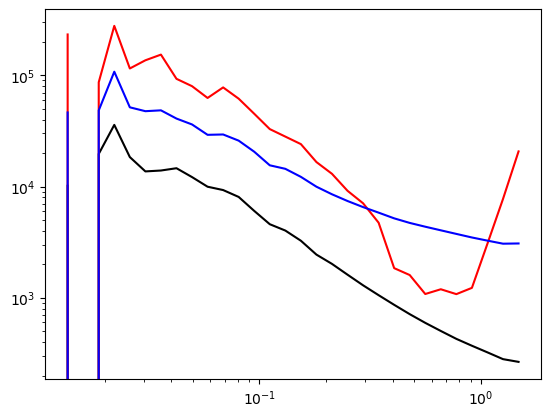

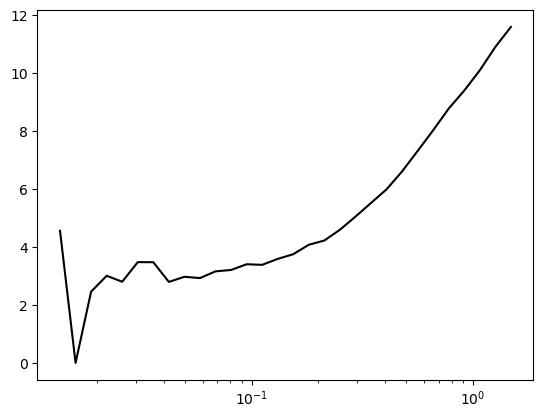

In [17]:
plt.xscale('log');plt.yscale('log')
plt.plot(ps.ktab,Pk_mm,'k-',label='matter')
plt.plot(ps.ktab,Pk_hh,'r-',label='halos')
plt.plot(ps.ktab,Pk_hm,'b-',label='cross')
plt.show()

plt.xscale('log')
plt.plot(ps.ktab,Pk_hm/Pk_mm,'k-',label='$b_1(k)$')
plt.show()

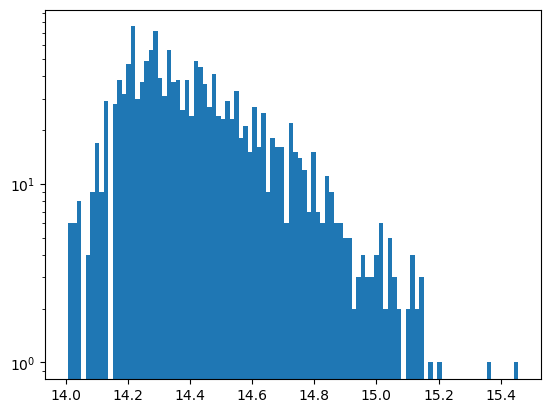

In [12]:
plt.yscale('log')
plt.hist(np.log10(halos['m200b']),bins=100)
plt.show()